# Eclipsing binary: Linear solution for the maps

In this notebook, we're going to use a linear solve to infer the surface maps of two stars in an eclipsing binary given the light curve of the system. We generated the data in [this notebook](EclipsingBinary_Generate.ipynb). This is a follow up to the [notebook](EclipsingBinary_PyMC3.ipynb) in which we solved the system using `pymc3`. Because `starry` is a linear model, we can actually solve the same problem *analytically* and in no time at all.

Let's begin with some imports. Note that we're again disabling the `lazy` evaluation to make things a bit easier, although this notebook would also work with that enabled.

In [19]:
%matplotlib inline

In [20]:
%run notebook_setup.py

<Figure size 1200x400 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import starry
from scipy.linalg import cho_solve
from corner import corner

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

## Load the data

Let's load the EB dataset as before:

In [4]:
# Run the Generate notebook if needed
if not os.path.exists("eb.npz"):
    import nbformat
    from nbconvert.preprocessors import ExecutePreprocessor

    with open("EclipsingBinary_Generate.ipynb") as f:
        nb = nbformat.read(f, as_version=4)
    ep = ExecutePreprocessor(timeout=600, kernel_name="python3")
    ep.preprocess(nb);

In [22]:
data = np.load("eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]

Instantiate the primary, secondary, and system objects. As before, we assume we know the true values of all the orbital parameters and star properties, *except* for the two surface maps. (If you just read the [PyMC3 notebook](EclipsingBinary_PyMC3.ipynb), note that we're no longer instantiating these within a `pymc3.Model` context.)

In [23]:
# Primary
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)
pri.map[1:] = A["u"]

# Secondary
sec = starry.Secondary(
    starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B["inc_rot"]),
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"],
    inc=B["inc_orb"]
)
sec.map[1:] = B["u"]

# System
sys = starry.System(pri, sec)

Here's the light curve we're going to do inference on:

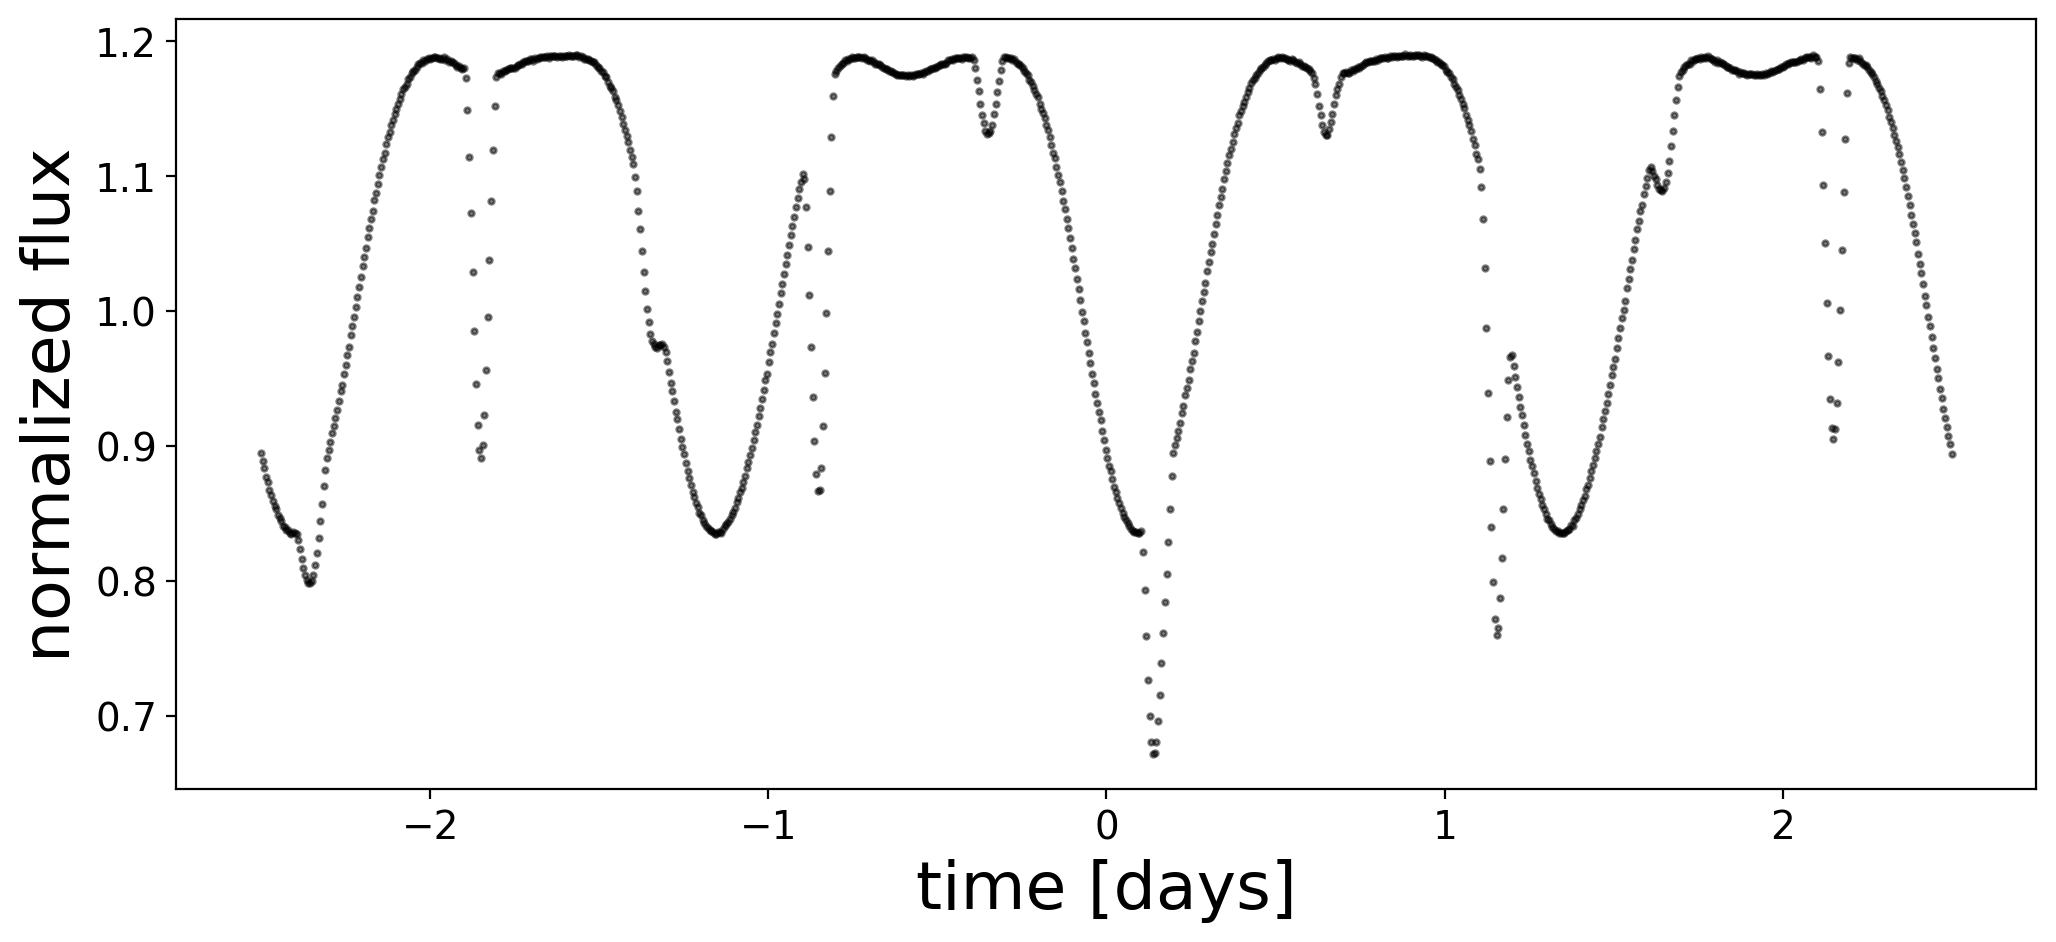

In [24]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

## Linear solve

In [25]:
# HACK: Pre-compile the solve function
# to get an accurate timing test below!
sys.set_data(np.array([0.0]), C=1.0)
pri.map.set_prior(L=1)
sec.map.set_prior(L=1)
sys.solve(t=np.array([0.0]))

In order to compute the posterior over maps, we need a prior for the spherical harmonic coefficients of each star. The linear solve **requires** Gausssian priors on the spherical harmonic coefficients; these are specified in terms of a mean vector $\mu$ (``mu``) and a covariance matrix $\Lambda$ (``L``). Recall that this is similar to what we did in the [PyMC3 notebook](EclipsingBinary_PyMC3.ipynb).

It is important to note that when using the linear solve feature in ``starry``, the prior is actually placed on the 
**amplitude-weighted** spherical harmonic coefficients. 
In other words, if $\alpha$ is the map amplitude (``map.amp``) and $y$ is the vector of spherical harmonic coefficients (``map.y``), we place a prior on the quantity $x \equiv \alpha y$. While this may be confusing at first, recall that the coefficient of the $Y_{0,0}$ harmonic is always **fixed at unity** in ``starry``, so we can't really solve for it. But we *can* solve for all elements of the vector $x$. Once we have the posterior for $x$, we can easily obtain both the amplitude (equal to $x_0$) and the spherical harmonic coefficient vector (equal to $x / x_0$). This allows us to simultaneously obtain both the amplitude and the coefficients using a single efficient linear solve.

Because of this convention, the first element of the mean and the first row/column of the covariance are special: they control the amplitude of the map. For maps whose baseline has been properly normalized, the mean $\mu_\alpha$ of this term should be equal to (or close to) one. Its variance $\lambda_\alpha$ (the first diagonal entry of the covariance) is the square of the uncertainty on the amplitude of the map.

The remaining elements are the prior on the $l>0$ spherical harmonic coefficients, weighted by the amplitude. For these, the easiest kind of prior we can place is an isotropic prior (no preferred direction), in which $\mu = 0$ and the corresponding block of $\Lambda$ is a diagonal matrix. In this case, the diagonal entries of $\Lambda$ are related to the power spectrum of the map. We'll discuss this in more detail later, but for now let's assume a flat power spectrum, in which there is no preferred scale, so $\Lambda = \lambda I$. The quantity $\lambda$ is essentially a regularization parameter, whose amplitude controls the relative weighting of the data and the prior in determining the posterior. 

For definiteness, we'll choose $\mu_\alpha = 1$ and $\lambda_\alpha = \lambda = 10^{-2}$ for the primary and $\mu_\alpha = 0.1$ and $\lambda_\alpha = \lambda = 10^{-4}$ for the secondary (i.e., we assume we know the secondary has one-tenth the luminosity of the primary, but we allow for some uncertainty in that value). Readers are encouraged to experiment with different values.

In [26]:
# Prior on primary
pri_mu = np.zeros(pri.map.Ny)
pri_mu[0] = 1.0
pri_L = np.zeros(pri.map.Ny)
pri_L[0] = 1e-2
pri_L[1:] = 1e-2
pri.map.set_prior(mu=pri_mu, L=pri_L)

# Prior on secondary
sec_mu = np.zeros(sec.map.Ny)
sec_mu[0] = 0.1
sec_L = np.zeros(sec.map.Ny)
sec_L[0] = 1e-4
sec_L[1:] = 1e-4
sec.map.set_prior(mu=sec_mu, L=sec_L)

(Note that $L$ may be a scalar, vector, or matrix, and `starry` will construct the covariance matrix for you. Alternatively, users may instead specify `cho_L`, the Cholesky factorization of the covariance matrix).

Next, we specify the data and data covariance $C$ (the measurement uncertainty):

In [27]:
sys.set_data(flux, C=sigma ** 2)

(As before, users can pass a scalar, vector or matrix as the data covariance, or the Cholesky factorization `cho_C`).

Finally, let's solve the linear problem! We do this by calling `sys.solve()` and passing the array of times at which to evaluate the light curve. The method returns the mean $\mu$ and Cholesky factorization $L$ of the posterior covariance for each body in the system. Let's time how long this takes:

In [28]:
mu, cho_cov = sys.solve(t=t)

The linear solve is **extremely fast**! Note that once we run the `solve` method, we can call the `draw` method to draw samples from the posterior. Let's do that and visualize a random sample from each map:

In [29]:
sys.draw()

In [30]:
pri.map.show(theta=np.linspace(0, 360, 50))

In [31]:
sec.map.show(theta=np.linspace(0, 360, 50))

We can compare these maps to the true maps:

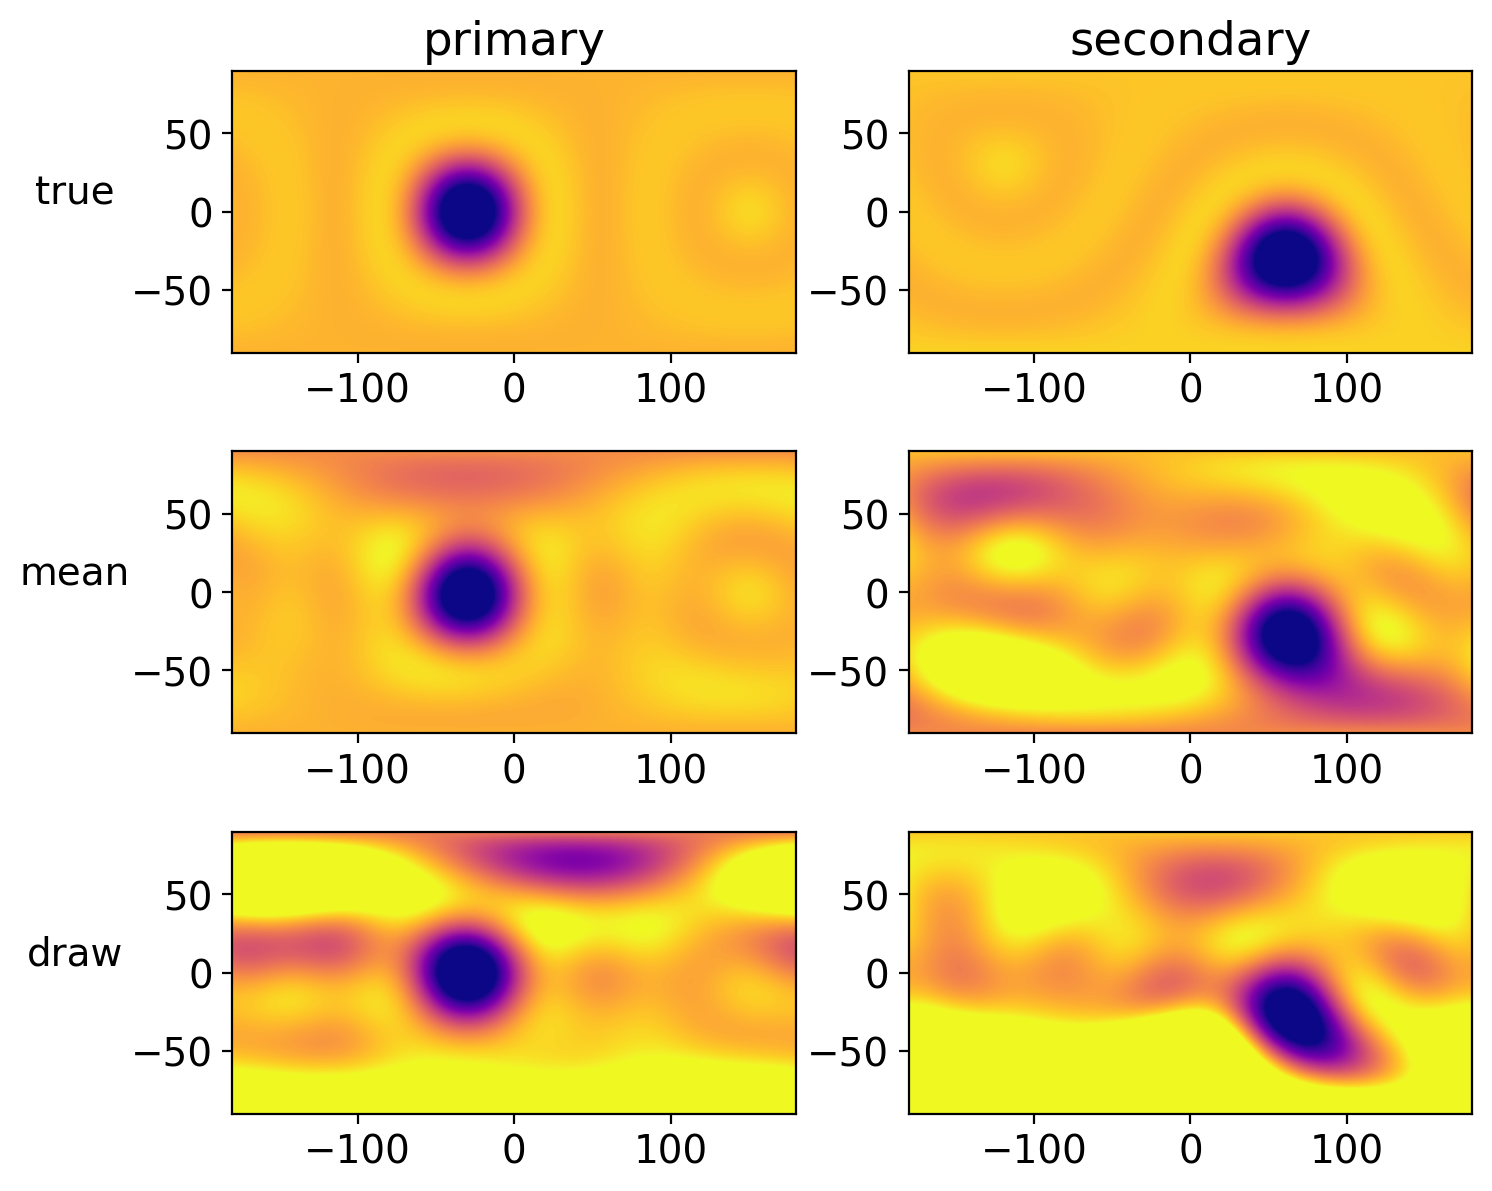

In [32]:
# true values
pri.map[1:, :] = A["y"]
pri.map.amp = A["amp"]
pri_true = pri.map.render(projection="rect")
sec.map[1:, :] = B["y"]
sec.map.amp = B["amp"]
sec_true = sec.map.render(projection="rect")

# mean values
pri.map.amp = mu[0]
pri.map[1:, :] = mu[1 : pri.map.Ny] / pri.map.amp
pri_mu = pri.map.render(projection="rect")
sec.map.amp = mu[pri.map.Ny]
sec.map[1:, :] = mu[pri.map.Ny + 1 :] / sec.map.amp
sec_mu = sec.map.render(projection="rect")

# a random draw
sys.draw()
pri_draw = pri.map.render(projection="rect")
sec_draw = sec.map.render(projection="rect")

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax[0, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("true", rotation=0, labelpad=20)
ax[1, 0].set_ylabel("mean", rotation=0, labelpad=20)
ax[2, 0].set_ylabel("draw", rotation=0, labelpad=20);

Not bad! Also note how similar these are to the results we got in the [PyMC3 notebook](EclipsingBinary_PyMC3.ipynb).

The other thing we can do is draw samples from this solution and plot the traditional corner plot for the posterior. Armed with the posterior mean `mu` and the Cholesky factorization of the covariance `cho_cov`, this is [super easy to do](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution). Let's generate 10000 samples from the posterior of the primary's surface map:

In [35]:
nsamples = 1000
u = np.random.randn(len(mu), nsamples)
samples = mu.reshape(1, -1) + np.dot(cho_cov, u).T

Here's the posterior for the amplitude and the first eight $l > 0$ coefficients of the primary:

RecursionError: maximum recursion depth exceeded

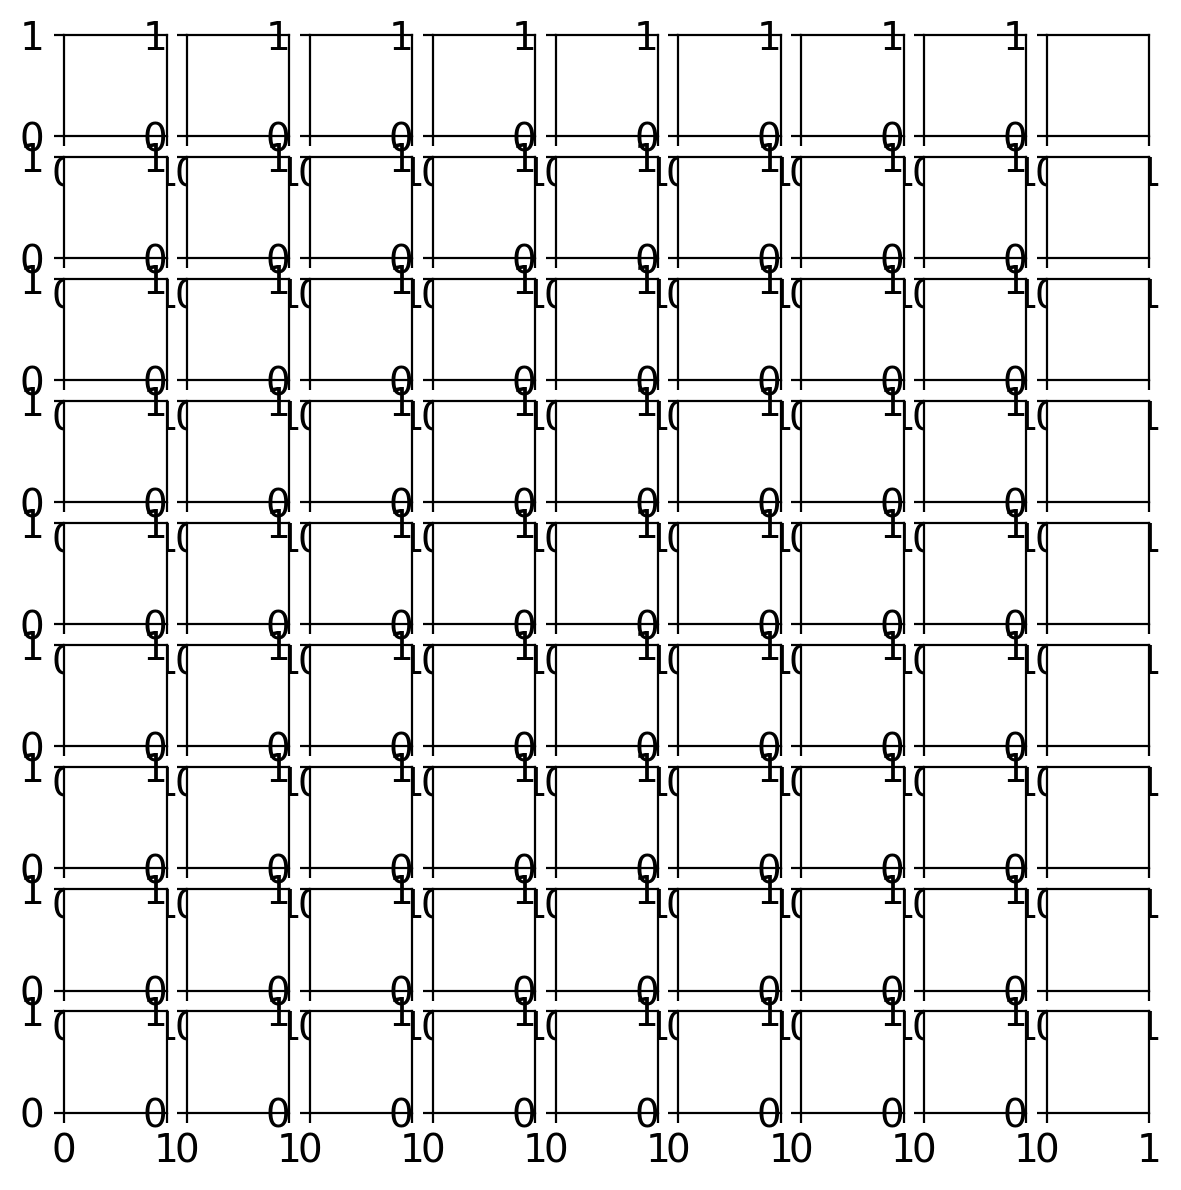

In [36]:
fig, ax = plt.subplots(9, 9, figsize=(7, 7))
labels = [r"$\alpha$"] + [
    r"$Y_{%d,%d}$" % (l, m)
    for l in range(1, pri.map.ydeg + 1)
    for m in range(-l, l + 1)
]

# De-weight the samples to get
# samples of the actual Ylm coeffs
samps = np.array(samples[:, :9])
samps[:, 1:] /= samps[:, 0].reshape(-1, 1)

corner(samps, fig=fig, labels=labels)
for axis in ax.flatten():
    axis.xaxis.set_tick_params(labelsize=6)
    axis.yaxis.set_tick_params(labelsize=6)
    axis.xaxis.label.set_size(12)
    axis.yaxis.label.set_size(12)
    axis.xaxis.set_label_coords(0.5, -0.6)
    axis.yaxis.set_label_coords(-0.6, 0.5)

Note that this is **exactly** the same covariance matrix we got in the [PyMC3 notebook](EclipsingBinary_PyMC3.ipynb) (within sampling error)!

So, just to recap: the spherical harmonics coefficients can be *linearly* computed given a light curve, provided we know everything else about the system. In most realistic cases we don't know the orbital parameters, limb darkening coefficients, etc. exactly, so the thing to do is to *combine* the linear solve with `pymc3` sampling. We'll do that in the [next notebook](EclipsingBinary_FullSolution.ipynb).